In [4]:
!git clone https://github.com/Toavina00/Zindi-credit-scoring
!cp -r /content/Zindi-credit-scoring/dataset .
!rm -rf /content/Zindi-credit-scoring

Cloning into 'Zindi-credit-scoring'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 3), reused 20 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 3.28 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv("dataset/Train.csv")
test  = pd.read_csv("dataset/Test.csv")

In [29]:
df = train.copy()

In [70]:
indicator = pd.read_csv("dataset/economic_indicators.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [71]:
indicator.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    27 non-null     object 
 1   Indicator  27 non-null     object 
 2   YR2001     20 non-null     float64
 3   YR2002     20 non-null     float64
 4   YR2003     20 non-null     float64
 5   YR2004     20 non-null     float64
 6   YR2005     24 non-null     float64
 7   YR2006     24 non-null     float64
 8   YR2007     24 non-null     float64
 9   YR2008     24 non-null     float64
 10  YR2009     24 non-null     float64
 11  YR2010     24 non-null     float64
 12  YR2011     24 non-null     float64
 13  YR2012     24 non-null     float64
 14  YR2013     24 non-null     float64
 15  YR2014     24 non-null     float64
 16  YR2015     21 non-null     float64
 17  YR2016     21 non-null     float64
 18  YR2017     21 non-null     float64
 19  YR2018     17 non-null     float64
 20  YR2019     1

## Data Preprocessing

In [35]:
from sklearn.feature_selection import mutual_info_classif, f_classif

In [242]:
def compute_woe_iv(df, feature, target, zero_division = 0.0):
    tab = pd.crosstab(df[feature], df[target])
    tab = tab.rename(columns={0: 'paid', 1: 'defaulted'})
    tab['paid'] += zero_division
    tab['defaulted'] += zero_division
    tab['woe'] = np.log((tab['paid'] / tab['paid'].sum()) / (tab['defaulted'] / tab['defaulted'].sum()))
    tab['iv'] = (tab['paid'] / tab['paid'].sum() - tab['defaulted'] / tab['defaulted'].sum()) * tab['woe']
    tab['iv'] = tab['iv'].cumsum()
    return tab[["woe"]], tab['iv'].iloc[-1]

### Discrete variables and Dates

In [243]:
iv_values = {}
for column in train.select_dtypes(include=['object', 'int64']).columns:
    if column != 'target':
        _, iv = compute_woe_iv(train, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

,Information Value
ID,inf
customer_id,inf
country_id,0.000000
tbl_loan_id,inf
lender_id,0.881658
loan_type,inf
disbursement_date,inf
due_date,inf
duration,inf
New_versus_Repeat,0.241688


In [244]:
df = train.copy()

In [245]:
df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)

iv_values = {}
for column in ['disbursement_year', 'disbursement_month', 'disbursement_day', 'due_year', 'due_month', 'due_day']:
    if column != 'target':
        _, iv = compute_woe_iv(df, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

,Information Value
disbursement_year,0.623276
disbursement_month,0.585795
disbursement_day,0.081691
due_year,inf
due_month,0.504325
due_day,0.077464


In [246]:
df_temp = df[["duration", "target"]]
df_temp["duration"] = df_temp["duration"].map(
    lambda x:
        "(0, 7]" if x <= 7 else
        "(7, 30]" if 7 < x <= 30 else
        "(30, 90]" if 30 < x <= 90 else
        "(90, 180]" if 90 < x <= 180 else
        "(180, 360]" if 180 < x <= 360 else
        "(360, )"
)

iv = compute_woe_iv(df_temp, "duration", "target")[1]

print(f"Information value: {iv}")

Information value: 0.8793294970877754


In [247]:
df_temp = df[["loan_type", "target"]]
df_temp["loan_type"] = df_temp["loan_type"].map(lambda x: 1 if x == "type_1" else 0)

iv = compute_woe_iv(df_temp, "loan_type", "target")[1]

print(f"Information value: {iv}")

Information value: 0.0


In [248]:
df = train.select_dtypes(include=['object', 'int64'])

df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)
df['duration'] = df['duration'].map(
    lambda x:
        "(0, 7]" if x <= 7 else
        "(7, 30]" if 7 < x <= 30 else
        "(30, 90]" if 30 < x <= 90 else
        "(90, 180]" if 90 < x <= 180 else
        "(180, 360]" if 180 < x <= 360 else
        "(360, )"
)

df = df.drop(columns=[
    'disbursement_date', 'due_date', "customer_id",
    "country_id", "tbl_loan_id", "lender_id",
    "loan_type", "ID"
    ])

iv_values = {}
for column in df.columns:
    if column != 'target':
        _, iv = compute_woe_iv(df, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

,Information Value
duration,0.879329
New_versus_Repeat,0.241688
disbursement_year,0.623276
disbursement_month,0.585795
disbursement_day,0.081691
due_year,inf
due_month,0.504325
due_day,0.077464


In [249]:
df = train.select_dtypes(include=['object', 'int64'])

df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)
df['duration'] = df['duration'].map(
    lambda x:
        0 if x <= 7 else
        1 if 7 < x <= 30 else
        2 if 30 < x <= 90 else
        3 if 90 < x <= 180 else
        4 if 180 < x <= 360 else
        5
)

df['New_versus_Repeat'] = df['New_versus_Repeat'].map(lambda x: 1 if x == "New Loan" else 0)

df = df.drop(columns=[
    'disbursement_date', 'due_date', "customer_id",
    "country_id", "tbl_loan_id", "lender_id",
    "loan_type", "ID"
    ])

mi_values = {}
for column in df.columns:
    if column != 'target':
        mi = mutual_info_classif(df[[column]], df['target'], discrete_features=True)[0]
        mi_values[column] = mi

pd.DataFrame(mi_values, index=["Mutual Information"]).T

,Mutual Information
duration,0.009844
New_versus_Repeat,0.002882
disbursement_year,0.006822
disbursement_month,0.006427
disbursement_day,0.000712
due_year,0.008018
due_month,0.005661
due_day,0.000691


### Continuous Variables

In [250]:
df = train.copy()

In [251]:
df_ind = indicator[["Country", "Indicator", "YR2020", "YR2021", "YR2022", "YR2023"]].dropna()

ind_dict = {}
country = df_ind["Country"].unique()
years = {k: int(k[2:])+1 for k in ["YR2020", "YR2021", "YR2022", "YR2023"]}
ind_list = []

for ind in df_ind["Indicator"].unique():
    if df_ind[df_ind["Indicator"] == ind].shape[0] == len(country):
        ind_list.append(ind)

for country in df_ind["Country"].unique():
    ind_dict[country] = {}
    for ind in ind_list:
        ind_dict[country][ind] = {}
        for k, v in years.items():
            ind_dict[country][ind][v] = df_ind[(df_ind["Country"] == country) & (df_ind["Indicator"] == ind)][k].values[0]

df['disbursement_year'] = pd.to_datetime(df['disbursement_date']).dt.year

for ind in ind_list:
    df[ind] = df.apply(lambda row: ind_dict[row['country_id']][ind][row['disbursement_year']], axis=1)

df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)
df["Repay_Rate_Lender"] = (df["Lender_portion_to_be_repaid"] + 1) / (df["Amount_Funded_By_Lender"] + 1)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 22 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   ID                                                    68654 non-null  object 
 1   customer_id                                           68654 non-null  int64  
 2   country_id                                            68654 non-null  object 
 3   tbl_loan_id                                           68654 non-null  int64  
 4   lender_id                                             68654 non-null  int64  
 5   loan_type                                             68654 non-null  object 
 6   Total_Amount                                          68654 non-null  float64
 7   Total_Amount_to_Repay                                 68654 non-null  float64
 8   disbursement_date                                     68

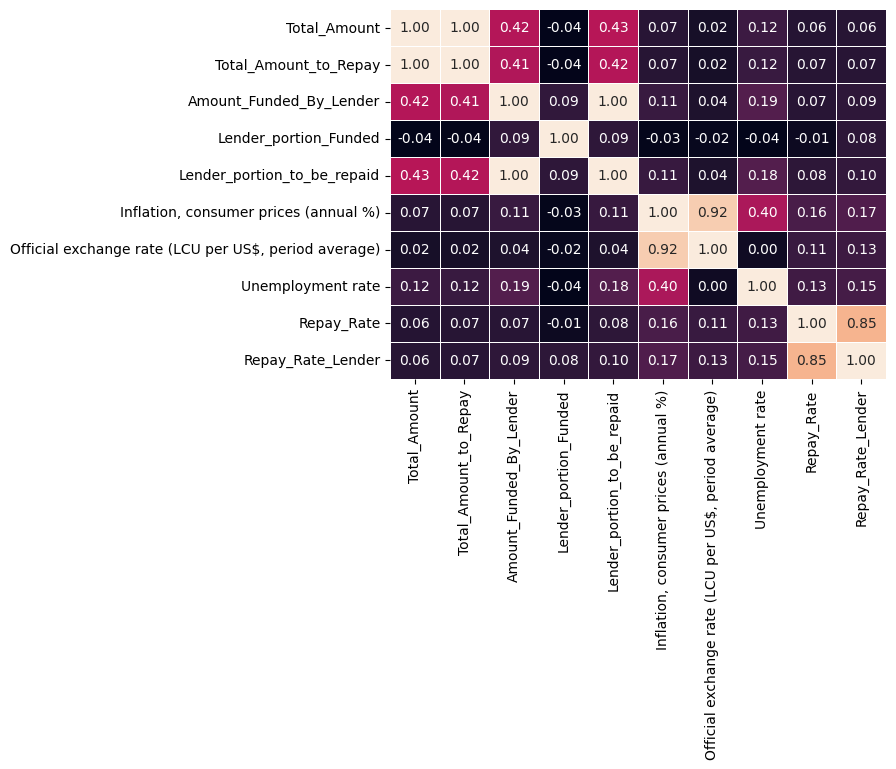

In [129]:
sns.heatmap(
    df.select_dtypes(include=np.float64).corr(),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False
)

plt.show()

-------------------- Density --------------------


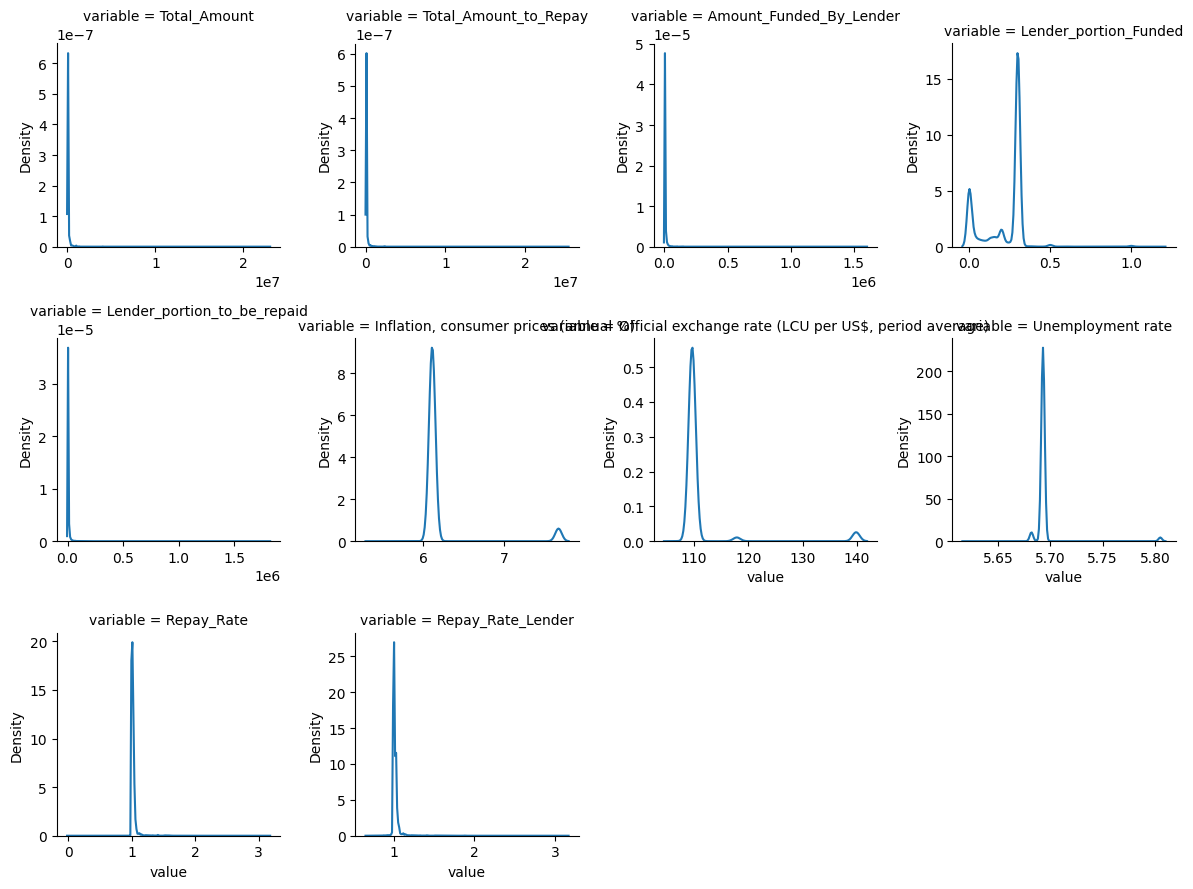

-------------------- Log Density --------------------


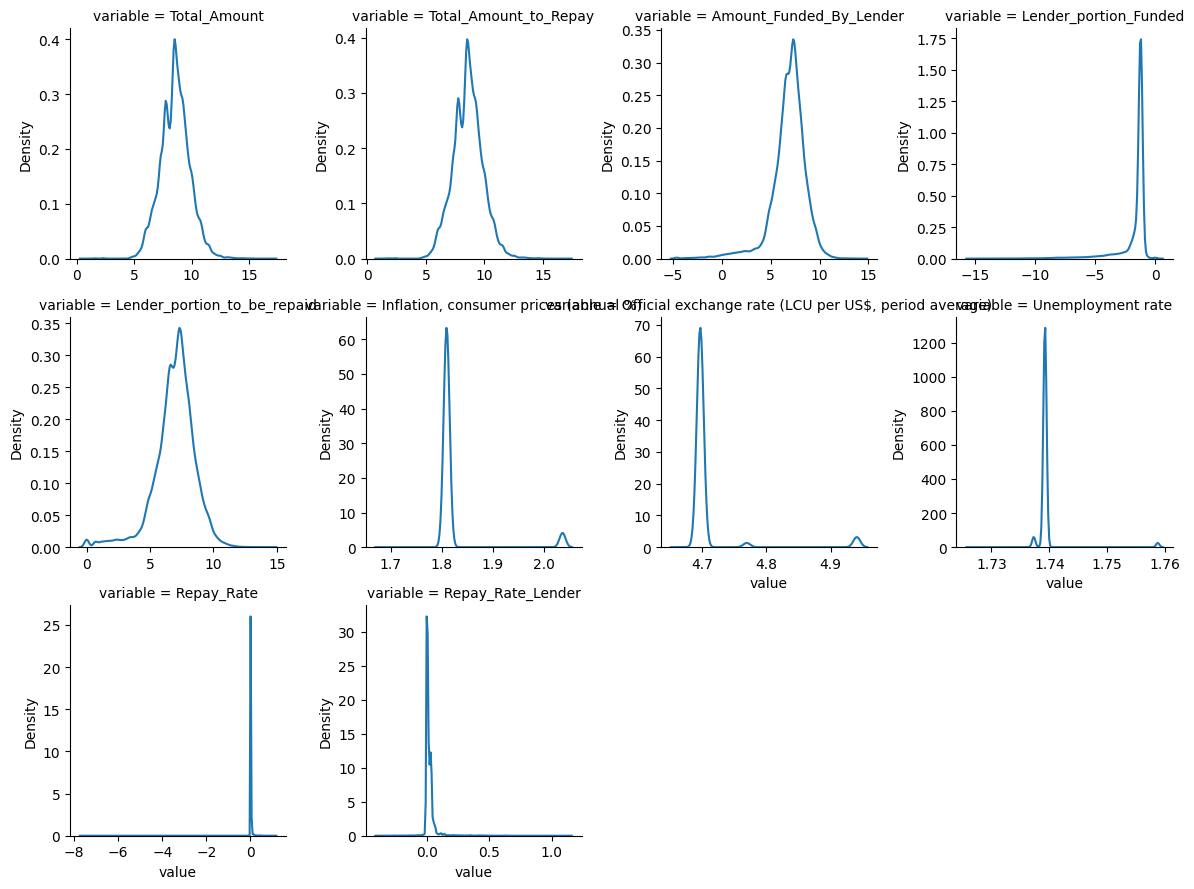

In [123]:
print("-"*20, "Density", "-"*20)

g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64)), col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

print("-"*20, "Log Density", "-"*20)

g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64).apply(np.log)), col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

In [124]:
df_log = df.select_dtypes(include=np.float64).transform(np.log)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True)

df_filtered = df.loc[df_log.index]

f_values, p_values = f_classif(df_log, df_filtered['target'])

f_test_results = pd.DataFrame({
    'Feature': df_log.columns,
    'F-Value': f_values,
    'P-Value': p_values
})

f_test_results

,Feature,F-Value,P-Value
0,Total_Amount,361.147868,2.735272e-80
1,Total_Amount_to_Repay,624.769709,3.491517e-137
2,Amount_Funded_By_Lender,224.133595,1.401675e-50
3,Lender_portion_Funded,0.023561,8.780069e-01
4,Lender_portion_to_be_repaid,388.914266,2.687280e-86
5,"Inflation, consumer prices (annual %)",1144.127849,1.909750e-248
6,"Official exchange rate (LCU per US$, period av...",882.779171,1.383371e-192
7,Unemployment rate,273.075320,3.317043e-61
8,Repay_Rate,52788.882597,0.000000e+00
9,Repay_Rate_Lender,46648.476173,0.000000e+00


In [125]:
float_columns = df.select_dtypes(include=['float64']).columns

mi_scores = mutual_info_classif(df[float_columns], df['target'])

mi_results = pd.DataFrame({
    'Feature': float_columns,
    'MI Score': mi_scores
})

mi_results

,Feature,MI Score
0,Total_Amount,0.012268
1,Total_Amount_to_Repay,0.013230
2,Amount_Funded_By_Lender,0.013936
3,Lender_portion_Funded,0.025285
4,Lender_portion_to_be_repaid,0.013796
5,"Inflation, consumer prices (annual %)",0.025877
6,"Official exchange rate (LCU per US$, period av...",0.024008
7,Unemployment rate,0.019506
8,Repay_Rate,0.069366
9,Repay_Rate_Lender,0.069044


### Preprocessing Pipe

In [411]:
def preprocess(df, indicator):

    df = df.copy()

    # Discrete features and date features
    df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(np.int64)
    df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(np.int64)
    df['New_versus_Repeat'] = df['New_versus_Repeat'].map(lambda x: 1 if x == "New Loan" else 0)

    # Continuous features
    df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)

    # Economical indicators
    df_ind = indicator[["Country", "Indicator", "YR2020", "YR2021", "YR2022", "YR2023"]].dropna()

    ind_dict = {}
    country = df_ind["Country"].unique()
    years = {k: int(k[2:])+1 for k in ["YR2020", "YR2021", "YR2022", "YR2023"]}
    ind_list = ["Inflation, consumer prices (annual %)", "Unemployment rate", "Official exchange rate (LCU per US$, period average)"]

    for country in df_ind["Country"].unique():
        ind_dict[country] = {}
        for ind in ind_list:
            ind_dict[country][ind] = {}
            for k, v in years.items():
                ind_dict[country][ind][v] = df_ind[(df_ind["Country"] == country) & (df_ind["Indicator"] == ind)][k].values[0]

    for ind in ind_list:
        df[ind] = df.apply(lambda row: ind_dict[row['country_id']][ind][row['disbursement_year']], axis=1)

    df.rename(columns={
        "Inflation, consumer prices (annual %)": "Inflation",
        "Unemployment rate": "Unemployment",
        "Official exchange rate (LCU per US$, period average)": "Exchange_Rate",
    }, inplace=True)

    # Drop columns
    df = df.drop(columns=[
        'disbursement_date', 'due_date', "customer_id",
        "country_id", "tbl_loan_id", "lender_id",
        "loan_type", "Total_Amount_to_Repay",
        "Lender_portion_to_be_repaid", "disbursement_year",
        "due_year", "Inflation", "due_day", "due_month"
    ])

    return df

## Model

In [431]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, TargetEncoder, FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier, plot_importance as lgb_plot_importance
from xgboost import XGBClassifier, plot_importance as xgb_plot_importance

set_config(transform_output="pandas")

In [413]:
df_train = preprocess(train, indicator)

X, y = df_train.drop(columns='target'), df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train,  X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       68654 non-null  object 
 1   Total_Amount             68654 non-null  float64
 2   duration                 68654 non-null  int64  
 3   New_versus_Repeat        68654 non-null  int64  
 4   Amount_Funded_By_Lender  68654 non-null  float64
 5   Lender_portion_Funded    68654 non-null  float64
 6   target                   68654 non-null  int64  
 7   disbursement_month       68654 non-null  int64  
 8   disbursement_day         68654 non-null  int64  
 9   Repay_Rate               68654 non-null  float64
 10  Unemployment             68654 non-null  float64
 11  Exchange_Rate            68654 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 6.3+ MB
None


In [416]:
class WoeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, zero_division=0.0, max_bin=None):
        self.woe = {}
        self.zero_division = zero_division
        self.max_bin = max_bin

    def fit(self, X, y):
        for column in X.columns:
            if self.max_bin and X[column].nunique() > self.max_bin:
                X[column] = pd.qcut(X[column], q=self.max_bin, duplicates='drop')

            tab = pd.crosstab(X[column], y)
            tab = tab.rename(columns={0: 'paid', 1: 'defaulted'})
            tab['paid'] += self.zero_division
            tab['defaulted'] += self.zero_division
            tab["woe"] = np.log((tab['paid'] / tab['paid'].sum()) / (tab['defaulted'] / tab['defaulted'].sum()))
            self.woe[column] = tab['woe'].to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            if self.max_bin and X[column].nunique() > self.max_bin:
                X_transformed[column] = pd.qcut(X_transformed[column], q=self.max_bin, duplicates='drop')
            X_transformed[column] = X_transformed[column].map(self.woe[column])
        return X_transformed


### Baseline

In [420]:
model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
                StandardScaler(),
            ), make_column_selector(dtype_include=np.float64)),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                WoeEncoder(1e-6),
                SimpleImputer(strategy='most_frequent'),
            ), make_column_selector(dtype_include=np.int64)
        ),
        remainder='drop'
    ),
    LogisticRegression(),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Train f1 score: ", f1_score(y_train, model.predict(X_train)))
print("Validation f1 score: ", f1_score(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

Train f1 score:  0.6126126126126126
Validation f1 score:  0.625


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10784
           1       0.78      0.52      0.62       201

    accuracy                           0.99     10985
   macro avg       0.88      0.76      0.81     10985
weighted avg       0.99      0.99      0.99     10985



### Models

In [423]:
model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
                #StandardScaler(),
            ), make_column_selector(dtype_include=np.float64)),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                #WoeEncoder(),
            ), make_column_selector(dtype_include=np.int64)
        ),
        remainder='drop'
    ),
    LGBMClassifier(verbose=-1, n_estimators=100, max_depth=3, random_state=42),
)

model.fit(X_train, y_train)

thresh = 0.5

y_val_pred   = (model.predict_proba(X_val)   > thresh).argmax(axis=1)
y_train_pred = (model.predict_proba(X_train) > thresh).argmax(axis=1)

model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

print("Train f1 score: ", f1_score(y_train, y_train_pred))
print("Validation f1 score: ", f1_score(y_val, y_val_pred))
print("\n")
print(classification_report(y_val, y_val_pred))

Train f1 score:  0.8489687292082502
Validation f1 score:  0.8333333333333334


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10784
           1       0.91      0.77      0.83       201

    accuracy                           0.99     10985
   macro avg       0.95      0.88      0.92     10985
weighted avg       0.99      0.99      0.99     10985



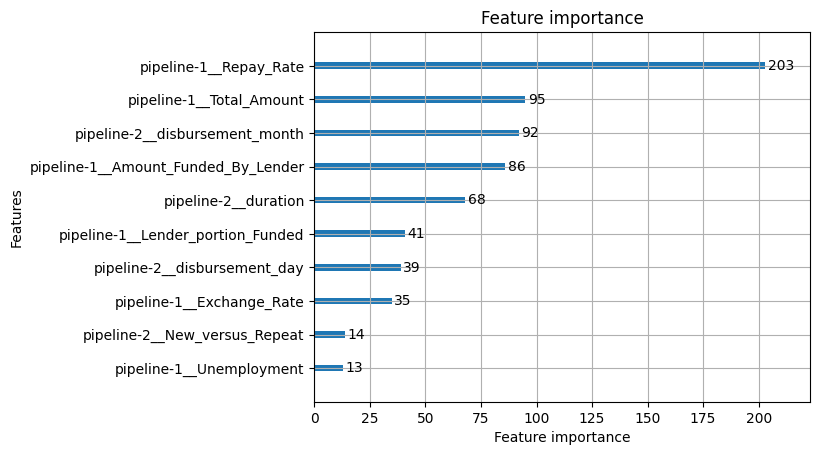

In [424]:
lgb_plot_importance(model[-1])

plt.show()

In [429]:
continuous_columns = X_train.select_dtypes(include=np.float64).columns
discrete_columns = X_train.select_dtypes(include=np.int64).columns

continuous_columns = continuous_columns.drop([

])

discrete_columns = discrete_columns.drop([

])

model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
            ), continuous_columns,
        ),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
            ), discrete_columns,
        ),
        remainder='drop'
    ),
    XGBClassifier(random_state=42),
)

model.fit(X_train, y_train)

thresh = 0.5

y_val_pred   = (model.predict_proba(X_val)   > thresh).argmax(axis=1)
y_train_pred = (model.predict_proba(X_train) > thresh).argmax(axis=1)

model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

print("Train f1 score: ", f1_score(y_train, y_train_pred))
print("Validation f1 score: ", f1_score(y_val, y_val_pred))
print("\n")
print(classification_report(y_val, y_val_pred))

Train f1 score:  0.9937733499377335
Validation f1 score:  0.8984771573604061


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10784
           1       0.92      0.88      0.90       201

    accuracy                           1.00     10985
   macro avg       0.96      0.94      0.95     10985
weighted avg       1.00      1.00      1.00     10985



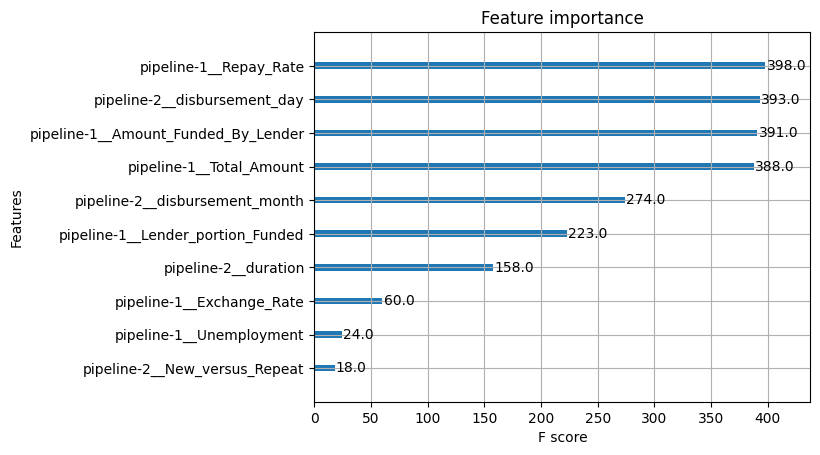

In [432]:
xgb_plot_importance(model[-1])

plt.show()

In [433]:
print("Test f1 score: ", f1_score(y_test, model.predict(X_test)))

Test f1 score:  0.8565656565656565


### Submission

In [434]:
# Make submission

df_test = preprocess(test, indicator)

model.fit(X, y)

y_pred = model.predict(df_test)

print(classification_report(y, model.predict(X)))

submission = pd.DataFrame({
    "ID": test["ID"],
    "target": y_pred
})

submission.to_csv("submission.csv", index=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67396
           1       0.99      0.98      0.99      1258

    accuracy                           1.00     68654
   macro avg       1.00      0.99      0.99     68654
weighted avg       1.00      1.00      1.00     68654



---